In [231]:
import hashlib
import json
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [329]:
# Input metadata.
exp_dirs_code_hashes = [['../experiment_data/pilot_june9/', 'thowpbr_pilot0'],
                        ['../experiment_data/pilot_june12a/', 'thowpbr_pilot0'],
                        ['../experiment_data/pilot_june12b/', 'thowpbr_pilot0']]

csv_name = 'mturk.csv'
log_dir = 'www/log/'
feedback_dir = 'www/feedback'

# Set by task tuple creation.
MIN_GOLD_NAV = 4
MAX_GOLD_NAV = 35

# Set by HIT.
ORACLE_FUTURE_LEN = 5

# Load house targets.
tasks_fn = 'resources/house_target_tuple.json'
with open(tasks_fn, 'r') as f:
    house_target_tuple = json.load(f)
    
# Compute paths through houses.
import networkx as nx
from generate_start_end_pairs import load_nav_graphs
house_hops = {}
for house in set(games['scan']):
    graph = load_nav_graphs([house])[house]
    hops = dict(nx.all_pairs_dijkstra_path(graph))
    house_hops[house] = hops
    
def get_shortest_planner_path(house, start_pano, end_panos):
    full_trajs = [house_hops[house][start_pano][end_pano] for end_pano in end_panos]
    full_traj_lens = [len(full_trajs[idx]) for idx in range(len(full_trajs))]
    return full_trajs[full_traj_lens.index(min(full_traj_lens))]
    
# Output metadata.
games_fn = '../tasks/dialog_navigation/all.json'
instruction_following_dir = '../tasks/instruction_following/'
question_asking_dir = '../tasks/question_asking/'
question_answering_dir = '../tasks/question_answering/'

In [287]:
# Read in the CSV from Turk and connect each player to their respective logfile to rebuild games.
num_unpaired = 0
players = pd.DataFrame(columns=["wid", "uid", "pid", "role", "rating", "feedback"])
games = pd.DataFrame(columns=["navigator",  # uid of the navigator
                              "oracle",  # uid of the oracle
                              "navigator_quality",  # rated quality of the navigator from the oracle
                              "oracle_quality",  # rated quality of the oracle from the navigator
                              "scan",  # the house the game took place in
                              "target",  # the target object described by the hint
                              "start_pano",  # the starting panorama
                              "end_panos",  # list of valid ending panoramas
                              "success",  # boolean whether the game was ended in a correct end_pano
                              "nav_steps",  # the panorama jumps taken during navigation (no camera movements)
                              "nav_camera",  # the camera movements preceeding nav steps where questions were asked
                              "dialog_history",  # the full dialog history (both navigator and oracle)
                              "stop_history",  # list of 'nav_step' idxs where navigator attempted a stop action
                              "planner_nav_steps",  # the path the planner would have taken from start to end
                              ])
for exp_dir, surveycode_hash in exp_dirs_code_hashes:
    print("Reading from '%s'" % exp_dir)
    mturk = pd.read_csv(os.path.join(exp_dir, csv_name))
    for idx in mturk.index:
        # Approve surveycode.
        surveycode = mturk['Answer.surveycode'][idx]
        wid = mturk['WorkerId'][idx]
        if '_' not in surveycode or surveycode.count('_') != 1:
            print('WARNING: worker %s has invalid surveycode "%s"' % (wid, surveycode))
            continue
        uid, hashcode = mturk['Answer.surveycode'][idx].split('_')
        hash_str = 'phm_salted_hash%s%s' % (uid, surveycode_hash)
        correcthash = hashlib.sha1(hash_str.encode('utf-8')).hexdigest()[:13]
        if correcthash != hashcode:
            print('WARNING: worker %s has wrong hash %s does not match target %s' % (wid, hashcode, correcthash))
            continue

        # Find the feedback file for this user.
        uid_feedback_fn = None
        for _, _, fns in os.walk(os.path.join(exp_dir, feedback_dir)):
            for fn in fns:
                if fn.split('.')[-1] == 'json' and fn.split('_')[0] == uid:
                    uid_feedback_fn = os.path.join(exp_dir, feedback_dir, fn)
        if uid_feedback_fn is None:
            print('WARNING: worker %s with uid %s has no feedback file' % (wid, uid))
            continue
        with open(uid_feedback_fn) as f:
            feedback = json.load(f)
        if len(feedback['navigator']) == 0 or len(feedback['oracle']) == 0:
            num_unpaired += 1
            continue
        role = 'navigator' if feedback['navigator'] == uid else 'oracle'
        pid_role = 'navigator' if role == 'oracle' else 'oracle'
        pid = feedback['navigator'] if role == 'oracle' else feedback['oracle']
        pid_rating = int(feedback['rating']) if feedback['rating'] is not None else None
        str_feedback = feedback['free_form_feedback']

        # Add self and partner to players dataframe.
        if pid_rating is None:
            continue
        for add_uid in [uid, pid]:
            if add_uid not in players['uid'].tolist():
                players = players.append({
                            "wid": None,
                            "uid": add_uid,
                            "pid": None,
                            "role": None,
                            "rating": None,
                            "feedback": None,
                        }, ignore_index=True)
        uid_idx = players.index[players['uid'] == uid].tolist()[0]
        players['wid'][uid_idx] = wid
        players['pid'][uid_idx] = pid
        players['role'][uid_idx] = role
        players['feedback'][uid_idx] = str_feedback
        pid_idx = players.index[players['uid'] == pid].tolist()[0]
        players['rating'][pid_idx] = pid_rating

        # Already have game information for this user.
        if pid in games['navigator'].tolist():
            gidx = games.index[games['navigator'] == pid].tolist()[0]
            games['oracle'][gidx] = uid
            games['navigator_quality'][gidx] = pid_rating
            continue
        elif pid in games['oracle'].tolist():
            gidx = games.index[games['oracle'] == pid].tolist()[0]
            games['navigator'][gidx] = uid
            games['oracle_quality'][gidx] = pid_rating
            continue

        # Find the logfile and partner id for this user.
        for _, _, fns in os.walk(os.path.join(exp_dir, log_dir)):
            for fn in fns:
                if ('.' in fn and fn.split('.')[-1] == 'log' and
                    '_' in fn and uid in fn.split('.')[0].split('_') and pid in fn.split('.')[0].split('_')):

                    # Need to create game information for this unseen pair.
                    navigator = oracle = navigator_quality = oracle_quality = None
                    house = target = start_pano = end_panos = None
                    success = False
                    nav_steps = []
                    nav_camera = []
                    dialog_history = []
                    stop_history = []
                    curr_pano = None
                    curr_camera_moves = []
                    curr_turn = "navigator"
                    with open(os.path.join(exp_dir, log_dir, fn)) as f:
                        logfile_lines = f.readlines()
                        for line in logfile_lines:
                            line_parts = line.strip().split('\t')
                            if len(line_parts) == 4:  # Newer format includes receiver.
                                time, sender, receiver, data_str = line_parts
                            else:  # Old format does not include receiver.
                                time, sender, data_str = line_parts
                            data_str = re.sub(r'(?!(([^"]*"){2})*[^"]*$)\'', "\\'", data_str)
                            data_str = data_str.replace("'", '"')
                            line_data = json.loads(data_str)

                            if line_data['action'] == 'set_house':
                                house = line_data['value']
                            elif line_data['action'] == 'set_target_obj':
                                target = line_data['value']
                            elif line_data['action'] == 'set_start_pano':
                                start_pano = line_data['value']
                                curr_pano = start_pano
                                nav_steps.append(curr_pano)
                            elif line_data['action'] == 'set_end_panos':
                                end_panos = line_data['value'].split(',')
                            elif line_data['action'] == 'enable_nav':
                                navigator = uid
                                oracle = pid
                                oracle_quality = pid_rating
                            elif line_data['action'] == 'show_gold_view':
                                oracle = uid
                                navigator = pid
                                navigator_quality = pid_rating
                            elif line_data['action'] == 'nav':
                                if line_data['message']['img_id'] != curr_pano:
                                    curr_pano = line_data['message']['img_id']
                                    nav_steps.append(curr_pano)
                                    curr_camera_moves = []
                                curr_camera_moves.append({'pano': line_data['message']['img_id'],
                                                          'heading': (line_data['message']['rot']['_x'] + 1) 
                                                          * np.pi,
                                                          'elevation': (line_data['message']['rot']['_y'] + 35)
                                                          * 0.5,
                                                         })
                            elif line_data['action'] == 'chat':
                                if curr_turn == 'navigator':  # add camera steps preceeding question
                                    nav_camera.append({"nav_idx": len(nav_steps) - 1,
                                                       "dia_idx": len(dialog_history),
                                                       "message": curr_camera_moves})
                                if curr_turn == role:
                                    dialog_history.append({"uid": uid,
                                                           "role": role,
                                                           "nav_idx": len(nav_steps) - 1,
                                                           "message": line_data['message'].replace('"', "'")})
                                else:
                                    dialog_history.append({"uid": pid,
                                                           "role": pid_role,
                                                           "nav_idx": len(nav_steps) - 1,
                                                           "message": line_data['message'].replace('"', "'")})
                                curr_turn = "navigator" if curr_turn == "oracle" else "oracle"
                            elif line_data['action'] == 'guess_stop':
                                stop_history.append(len(nav_steps))
                            elif line_data['action'] == 'set_aux' and 'Congrats, ' in line_data['message']:
                                success = True
                                
                        planner_nav_steps = get_shortest_planner_path(house, start_pano, end_panos)

                        games = games.append({
                            "navigator": navigator,
                            "oracle": oracle,
                            "navigator_quality": navigator_quality,
                            "oracle_quality": oracle_quality,
                            "scan": house,
                            "target": target,
                            "start_pano": start_pano,
                            "end_panos": end_panos,
                            "success": success,
                            "nav_steps": nav_steps,
                            "nav_camera": nav_camera,
                            "dialog_history": dialog_history,
                            "stop_history": stop_history,
                            "planner_nav_steps": planner_nav_steps,
                        }, ignore_index=True)
print("Got %d players over %d games (%d won); %d players were left unpaired" %
      (len(players), len(games), len(games['success']), num_unpaired))
# TODO: determine why 'lost' games aren't being read in and correct this.

with open(games_fn, 'w') as f:
    json.dump(games.to_json(), f)

Reading from '../experiment_data/pilot_june9/'
Reading from '../experiment_data/pilot_june12a/'
Reading from '../experiment_data/pilot_june12b/'
Got 44 players over 22 games (22 won); 26 players were left unpaired


In [273]:
# See players' success rates and ratings.
player_ratings = {}
player_success = {}
for idx in players.index:
    wid = players['wid'][idx]
    if wid not in player_ratings:
        player_ratings[wid] = []
        player_success[wid] = []
    player_ratings[wid].extend(games[games['navigator'] == players['uid'][idx]]['navigator_quality'])
    player_ratings[wid].extend(games[games['oracle'] == players['uid'][idx]]['oracle_quality'])
    player_success[wid].extend(games[games['navigator'] == players['uid'][idx]]['success'])
for wid in player_ratings:
    print(wid, player_ratings[wid], player_success[wid])

A3PTO0DMF57GDG [3] []
A2R89RXGEVG05I [5] [True]
AO33H4GL9KZX9 [5] [True]
A2LC2DS8OH7NCA [5] []
A3CPQP08A6J09F [4] [True]
A3NMQ3019X6YE0 [5] []
A272X64FOZFYLB [5] []
A1YKFB1EKM08EV [5] [True]
A2UTDZAZV1DF0N [5, 5] [True]
A3APKUC67F9IMW [4] [True]
A248LF7KKHXZ14 [5, 5] [True]
A2HC9549CZAKNN [3] [True]
A1H1TKK54YG94Q [5] []
A1IZ4NX41GKU4X [2] []
A14Z1JSAR9JEON [4] []
AUFUUD4WG9CVO [5] []
A2TUUIV61CR0C7 [5] []
AAIQLE701DI9U [1] [True]
A13WYZ8AXD6ODX [5] [True]
A1AKL5YH9NLD2V [4] [True]
A17TKHT8FEVH0R [3] []
A10JXOU89D5RXR [5] []
A1VAL7L9L79IN0 [5] [True]
A2G7DTL156PTKA [5] []
A3W6T1WDYXMR3 [5] [True]
A2YE7NBCK14VAQ [4] []
AZOK0NYBJ9ZCS [3] [True]
A2EKR2ZFO10VMV [2] [True]
A27OFCQG73Z4UF [5] [True]
ALF9AAZGQP4K5 [2] []
A3CH1Z6J9R38G9 [4, 5] []
AOIK8K4X34LGR [5] [True]
A13CXQGLSH6QY8 [5] []
A3CWEIEY3TGJFX [5] [True]
A20FTMW1E6AR1T [3] [True]
A3QEVFM3UD67BA [4, 5] [True]
A2X977GVQ6L90X [5] []
A1WR3WTEHJEY2D [4] [True]
AOS2PVHT2HYTL [3] []
A38LEVBZ3P5F6T [5] [True]


10	6	(0.60)
20	16	(0.80)
31	13	(0.42)
38	13	(0.34)
27	19	(0.70)
36	25	(0.69)
50	35	(0.70)
48	9	(0.19)
26	19	(0.73)
19	15	(0.79)
27	15	(0.56)
15	13	(0.87)
39	13	(0.33)
20	16	(0.80)
37	22	(0.59)
11	7	(0.64)
29	26	(0.90)
32	22	(0.69)
7	6	(0.86)
39	20	(0.51)


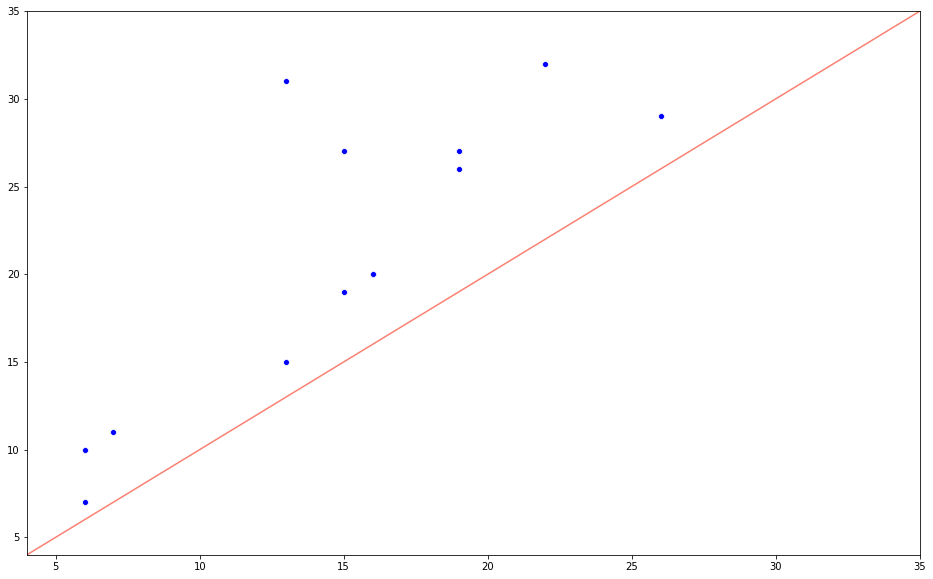

In [274]:
# Nav lengths against shortest path for completed games.
player_lens = []
shortest_lens = []
for idx in games.index:
    if not games['success'][idx]:
        continue
    player_traj_len = len(games['nav_steps'][idx])
    shortest_traj_len = None
    for obj, start_pano, _, end_panos, end_pano_ds in house_target_tuple[games['scan'][idx]]:
        if (start_pano == games['start_pano'][idx] and
                obj == games['target'][idx] and
                set(end_panos) == set(games['end_panos'][idx])):
            shortest_traj_len = min(end_pano_ds)
    if shortest_traj_len is not None:
        print("%d\t%d\t(%.2f)" % (player_traj_len, shortest_traj_len, float(shortest_traj_len / player_traj_len)))
        player_lens.append(player_traj_len)
        shortest_lens.append(shortest_traj_len)
    else:
        print("WARNING: task for house %s, target '%s' missing" % (games['scan'][idx], games['target'][idx]))
        
# Scatterplot showing how well players did against gold shortest.
fig, ax = plt.subplots(figsize=(16, 10))
g1 = sns.scatterplot(ax=ax, x=shortest_lens, y=player_lens, color='blue')
g2 = sns.lineplot(ax=ax, x=[MIN_GOLD_NAV, MAX_GOLD_NAV], y=[MIN_GOLD_NAV, MAX_GOLD_NAV], color='salmon')  # Perfect
ax.set(xlim=(MIN_GOLD_NAV, MAX_GOLD_NAV), ylim=(MIN_GOLD_NAV, MAX_GOLD_NAV))
plt.show()

37	11	(3.36)
10	1	(10.00)
20	11	(1.82)
131	19	(6.89)
31	5	(6.20)
38	13	(2.92)
27	9	(3.00)
36	11	(3.27)
50	21	(2.38)
48	17	(2.82)
26	7	(3.71)
19	5	(3.80)
27	7	(3.86)
15	7	(2.14)
39	13	(3.00)
20	7	(2.86)
37	7	(5.29)
11	9	(1.22)
29	15	(1.93)
32	13	(2.46)
7	3	(2.33)
39	15	(2.60)


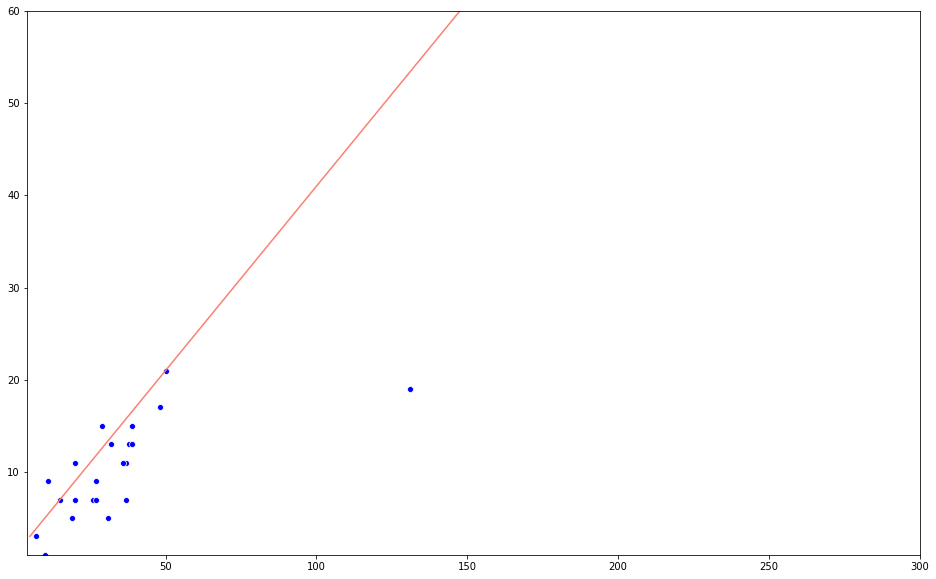

In [275]:
# Nav lengths against dialog lengths for completed games
nav_lens = []
dialog_lens = []
for idx in games.index:
    if not games['success'][idx]:
        continue
    nav_len = len(games['nav_steps'][idx])
    dialog_len = len(games['dialog_history'][idx]) + 1  # Counts the initial "hint" as a turn to avoid div by zero
    print("%d\t%d\t(%.2f)" % (nav_len, dialog_len, float(nav_len / dialog_len)))
    nav_lens.append(nav_len)
    dialog_lens.append(dialog_len)
        
# Scatterplot showing how well players did against gold shortest.
fig, ax = plt.subplots(figsize=(16, 10))
g1 = sns.scatterplot(ax=ax, x=nav_lens, y=dialog_lens, color='blue')
# "Conservative", asking 1 question every 5 nav turns, gives 2 dialog turns per 5 nav, with an offset of +1 for hint.
g2 = sns.lineplot(ax=ax, x=[5, 5*MAX_DIALOG_LEN], y=[2+1, (2*MAX_DIALOG_LEN)+1], color='salmon')
ax.set(xlim=(MIN_GOLD_NAV, MAX_NAV_LEN), ylim=(1, MAX_DIALOG_LEN))
plt.show()

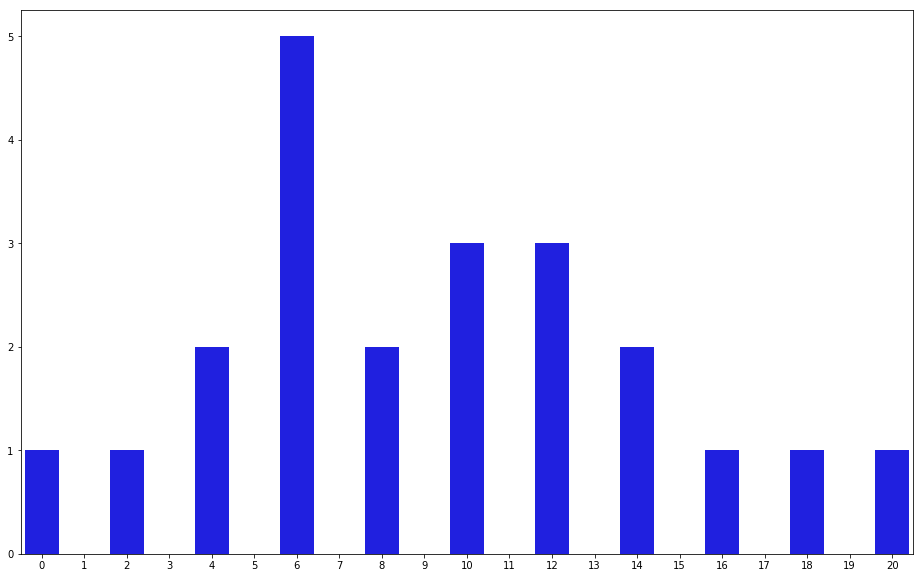

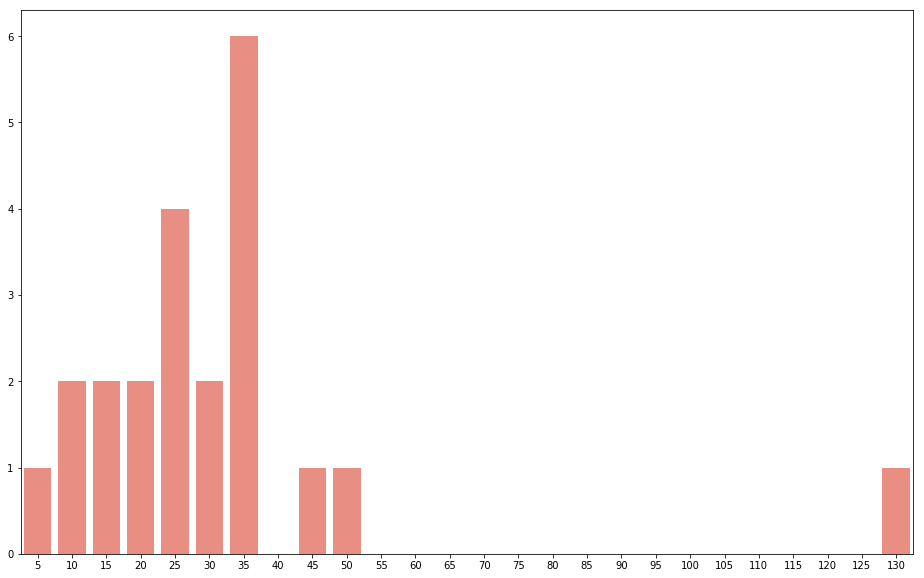

In [276]:
# Distribution of trajectory and dialog lengths.

# Dialog lens.
dialog_bin_size = 1
freq_of_dialog_count_bins = {}
for idx in games.index:
    if not games['success'][idx]:
        continue
    c = len(games['dialog_history'][idx])
    cbin = c // dialog_bin_size
    if cbin not in freq_of_dialog_count_bins:
        freq_of_dialog_count_bins[cbin] = 0
    freq_of_dialog_count_bins[cbin] += 1
for cbin in range(min(freq_of_dialog_count_bins), max(freq_of_dialog_count_bins)):
    if cbin not in freq_of_dialog_count_bins:
        freq_of_dialog_count_bins[cbin] = 0
        
# Nav lens.
nav_bin_size = 5
freq_of_nav_count_bins = {}
for idx in games.index:
    if not games['success'][idx]:
        continue
    c = len(games['nav_steps'][idx])
    cbin = c // nav_bin_size
    if cbin not in freq_of_nav_count_bins:
        freq_of_nav_count_bins[cbin] = 0
    freq_of_nav_count_bins[cbin] += 1
for cbin in range(min(freq_of_nav_count_bins), max(freq_of_nav_count_bins)):
    if cbin not in freq_of_nav_count_bins:
        freq_of_nav_count_bins[cbin] = 0

fig1, ax1 = plt.subplots(figsize=(16, 10))
g1 = sns.barplot(ax=ax1,
                 x=[k * dialog_bin_size for k in freq_of_dialog_count_bins],
                 y=[freq_of_dialog_count_bins[k] for k in freq_of_dialog_count_bins],
                 color="blue")
fig2, ax2 = plt.subplots(figsize=(16, 10))
g2 = sns.barplot(ax=ax2,
                 x=[k * nav_bin_size for k in freq_of_nav_count_bins],
                 y=[freq_of_nav_count_bins[k] for k in freq_of_nav_count_bins],
                 color="salmon")
plt.show()

In [277]:
analyze_target = 0  # 0 - word tokens, 1 - pos tags from spacy

def add_to_count_dict(tks, d):
    for tk_pos in tks:
        target = tk_pos[analyze_target]
        if target not in d:
            d[target] = 0
        d[target] += 1

import spacy
nlp = spacy.load("en_core_web_sm")

# Process language into structures.
all_wc = {}
nav_wc = {}
ora_wc = {}
len_at_nav_turn = [[] for _ in range(MAX_NAV_LEN)]
len_at_dialog_turn = [[] for _ in range(MAX_DIALOG_LEN)]
for idx in games.index:
    if not games['success'][idx]:
        continue
    for tidx in range(len(games['dialog_history'][idx])):
        turn = games['dialog_history'][idx][tidx]
        tks = [(tk.text.lower().strip(), tk.pos_) for tk in nlp(turn['message'])]
        tks = [(tk_s, tk_pos) for (tk_s, tk_pos) in tks if len(tk_s) > 0]
        add_to_count_dict(tks, all_wc)
        if turn['role'] == 'navigator':
            add_to_count_dict(tks, nav_wc)
        else:
            add_to_count_dict(tks, ora_wc)
        len_at_nav_turn[turn['nav_idx']].append(len(tks))
        len_at_dialog_turn[tidx].append(len(tks))
len_at_nav_turn = [len_at_nav_turn[idx] for idx in range(len(len_at_nav_turn))
                   if np.any([len(len_at_nav_turn[jdx]) > 0 for jdx in range(idx, len(len_at_nav_turn))])]
len_at_dialog_turn = [len_at_dialog_turn[idx] for idx in range(len(len_at_dialog_turn))
                   if np.any([len(len_at_dialog_turn[jdx]) > 0 for jdx in range(idx, len(len_at_dialog_turn))])]

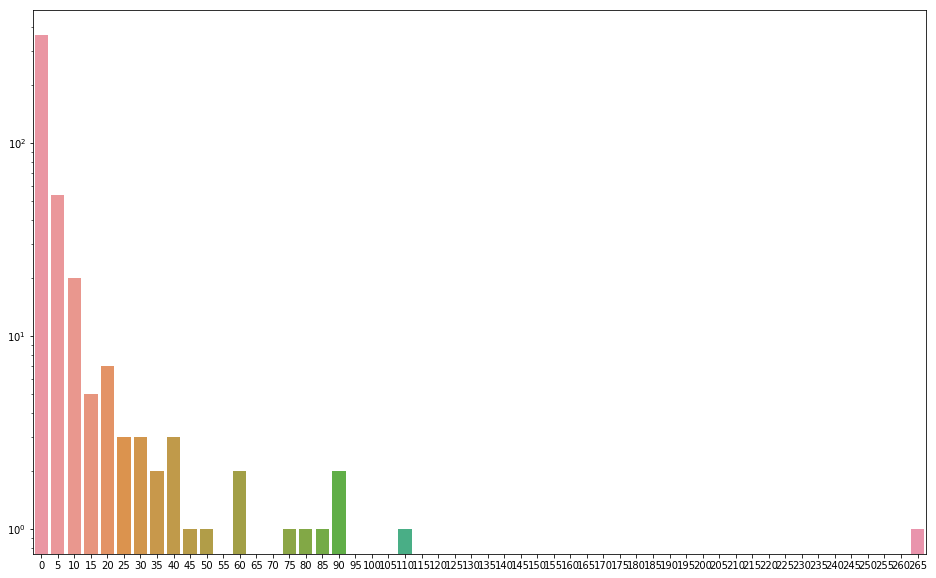

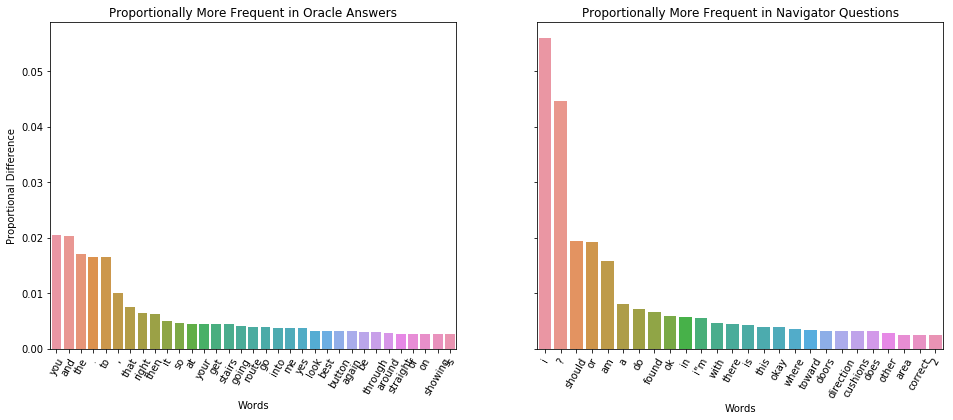

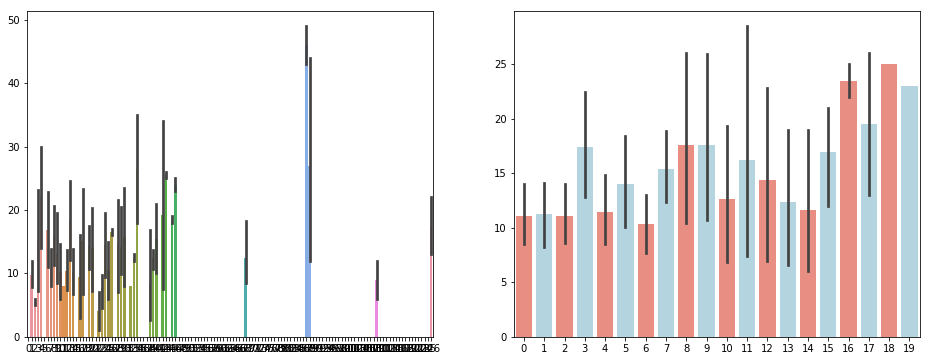

In [278]:
def flip_dict(d):
    g = {}
    for key in d:
        if d[key] not in g:
            g[d[key]] = []
        g[d[key]].append(key)
    return g

# Distribution of 1 grams
all_cw = flip_dict(all_wc)

bin_size = 5
freq_count_bins = {}
for w in all_wc:
    c = all_wc[w]
    cbin = c // bin_size
    if cbin not in freq_count_bins:
        freq_count_bins[cbin] = 0
    freq_count_bins[cbin] += 1
for cbin in range(min(freq_count_bins), max(freq_count_bins)):
    if cbin not in freq_count_bins:
        freq_count_bins[cbin] = 0
        
fig, ax = plt.subplots(figsize=(16, 10))
g = sns.barplot(ax=ax,
                x=[k * bin_size for k in freq_count_bins],
                y=[freq_count_bins[k] for k in freq_count_bins])
ax.set(yscale="log")
plt.show()

# Differences between navigator and oracle utterances
all_voc = set(all_wc.keys())
nav_wc_sum = sum([nav_wc[token] for token in nav_wc])
norm_nav_wc = {token: nav_wc[token] / nav_wc_sum if token in nav_wc else 0 for token in all_voc}
ora_wc_sum = sum([ora_wc[token] for token in ora_wc])
norm_ora_wc = {token: ora_wc[token] / ora_wc_sum if token in ora_wc else 0 for token in all_voc}
sum_ora_diffs = {token: norm_nav_wc[token] - norm_ora_wc[token] for token in all_voc}
tk_diffs = sorted(sum_ora_diffs.items(), key=lambda kv: kv[1])

threshold = 0.0025
rotation = 60
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(16, 6))
ax1.title.set_text('Proportionally More Frequent in Oracle Answers')
ax1.set(xlabel='Words', ylabel='Proportional Difference')
g1 = sns.barplot(x=[pair[0] for pair in tk_diffs if pair[1] < -threshold],
            y=np.array([-pair[1] for pair in tk_diffs  if pair[1] < -threshold]), ax=ax1)
g1.set_xticklabels(ax1.get_xticklabels(), rotation=rotation)
ax2.title.set_text("Proportionally More Frequent in Navigator Questions")
ax2.set(xlabel='Words')
g2 = sns.barplot(x=[pair[0] for pair in reversed(tk_diffs) if pair[1] > threshold],
            y=np.array([pair[1] for pair in reversed(tk_diffs) if pair[1] > threshold]), ax=ax2)
g2.set_xticklabels(ax2.get_xticklabels(), rotation=rotation)
plt.show()

# Utterance length against navigation step and dialog turn.
# TODO: two nav bars per step, one for navigator, one for oracle
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(16, 6))
g1 = sns.barplot(data=len_at_nav_turn, ax=ax1)
g2 = sns.barplot(data=len_at_dialog_turn, ax=ax2,
                palette=['salmon' if idx % 2 == 0 else 'lightblue' for idx in range(len(len_at_dialog_turn))])
plt.show()

In [320]:
# Note train/val unseen/test scans and ratios.
r2r_data_dir = '../../../tasks/R2R/data/'
r2r_data_folds = ["train", "val_seen", "val_unseen", "test"]
scans_by_fold = {}
trajs_by_fold = {}
for data_fold in r2r_data_folds:
    scans_by_fold[data_fold] = set()
    trajs_by_fold[data_fold] = 0
    with open(os.path.join(r2r_data_dir, "R2R_%s.json" % data_fold), 'r') as f:
        mp_data = json.load(f)
    for trajectory in mp_data:
        scans_by_fold[data_fold].add(trajectory['scan'])
        trajs_by_fold[data_fold] += 1
prop_val_seen = trajs_by_fold['val_seen'] / (trajs_by_fold['val_seen'] + trajs_by_fold['train'])
prop_train = trajs_by_fold['train'] / (trajs_by_fold['val_seen'] + trajs_by_fold['train'])

# Split games into train/val seen/val unseen/test.
np.random.seed(37)  # fix the seed so train/val_seen splits are identical given same data
assigned_train = None  # indices assigned to train
folds_to_games = {}
for fold in r2r_data_folds:
    gidxs = [idx for idx in games.index if games['scan'][idx] in scans_by_fold[fold]]
    if fold == "train":
        indices = list(range(len(gidxs)))
        np.random.shuffle(indices)
        train_n = min(int(np.round(prop_train * len(gidxs))), len(indices) - 1)
        assigned_train = set([gidxs[idx] for idx in indices[:train_n]])
        gidxs = assigned_train
    elif fold == "val_seen":
        indices = list(range(len(gidxs)))
        gidxs = [gidx for gidx in gidxs if gidx not in assigned_train]
    folds_to_games[fold] = gidxs

print("fold, num games")
for fold in r2r_data_folds:
    print("%s, %s" % (fold, len(folds_to_games[fold])))

fold, num games
train, 13
val_seen, 1
val_unseen, 3
test, 5


In [334]:
# Carve out the Instruction Following task.
ins_follow = pd.DataFrame(columns=["game_idx",  # meta - the game dialog from which this was extracted.
                                   "scan",  # setting - the house the task takes place in.
                                   "target",  # setting - the target object for the task.
                                   "start_pano",  # setting - the starting pano and camera angles for navigation.
                                   "dialog_history",  # input - dialog history so far.
                                   "nav_history",  # input - navigation pano steps so far.
                                   "nav_camera",  # input - camera movements at last pano up to question.
                                   "planner_path",  # output - the planner sequence steps shown to the oracle.
                                   "player_path",  # output - the steps the navigator actually took.
                                  ])
q_asking = pd.DataFrame(columns=["game_idx",  # meta - the game dialog from which this was extracted.
                                 "scan",  # setting - the house the task takes place in.
                                 "target",  # setting - the target object for the task.
                                 "start_pano",  # setting - the starting pano and camera angles for navigation.
                                 "dialog_history",  # input - dialog history so far.
                                 "nav_history",  # input - navigation pano steps so far.
                                 "nav_camera",  # input - camera movements at last pano up to question.
                                 "nav_question",  # output - the question the navigator asked at this step.
                                ])
q_answering = pd.DataFrame(columns=["game_idx",  # meta - the game dialog from which this was extracted.
                                    "scan",  # setting - the house the task takes place in.
                                    "target",  # setting - the target object for the task.
                                    "start_pano",  # setting - the starting pano and camera angles for navigation.
                                    "dialog_history",  # input - dialog history so far.
                                    "nav_history",  # input - navigation pano steps so far.
                                    "nav_camera",  # input - camera movements at last pano up to question.
                                    "planner_path",  # input - the planner sequence steps shown to the oracle.
                                    "oracle_answer",  # output - the answer the oracle gave
                                ])

for idx in games.index:
    if not games['success'][idx]:
        continue
    for tidx in range(len(games['dialog_history'][idx])):
        turn = games['dialog_history'][idx][tidx]
        if turn['role'] == 'oracle':  # Create a new instance of the instruction following task.
            
            # dialog history is everything before this answer + this answer.
            dialog_history = games['dialog_history'][idx][:tidx + 1]
            dialog_history = [{c: entry[c] for c in ['message', 'role', 'nav_idx']} for entry in dialog_history]

            # nav steps are all steps taken before this q and the one from which this q was answered.
            nav_steps = games['nav_steps'][idx][:turn['nav_idx'] + 1]
            
            # nav camera movements are those associated with this answers nav question.
            nav_camera = None
            for nav_camera_entry in games['nav_camera'][idx]:
                if nav_camera_entry['dia_idx'] == tidx - 1:  # e.g., -1 from oracle answer to nav question.
                    nav_camera = nav_camera_entry['message']
                    
            # the last message from the camera movements is our starting pano+angles
            start_pano = nav_camera[-1]
            # calculate the planner steps shown to the oracle from here to min(goal, +5) ahead.
            shortest_traj = get_shortest_planner_path(games['scan'][idx],
                                                      start_pano['pano'],
                                                      games['end_panos'][idx])
            planner_steps = shortest_traj[:min(5, len(shortest_traj))]
            
            # record the player steps taken until the next question was asked / goal was reached.
            if tidx + 1 < len(games['dialog_history'][idx]):
                next_nav_idx = games['dialog_history'][idx][tidx + 1]['nav_idx']
            else:
                next_nav_idx = len(games['nav_steps'][idx]) - 1
            # Navigator did not move before asking another question.
            if next_nav_idx == turn['nav_idx']:
                continue
            player_steps = list(games['nav_steps'][idx])[turn['nav_idx']:next_nav_idx + 1]
            
            ins_follow = ins_follow.append({"game_idx": idx,
                                            "scan": games['scan'][idx],
                                            "target": games['target'][idx],
                                            "start_pano": start_pano,
                                            "dialog_history": dialog_history,
                                            "nav_history": nav_steps,
                                            "nav_camera": nav_camera,
                                            "planner_path": planner_steps,
                                            "player_path": player_steps,
                                           }, ignore_index=True)
            q_asking = q_asking.append({"game_idx": idx,
                                        "scan": games['scan'][idx],
                                        "target": games['target'][idx],
                                        "start_pano": start_pano,
                                        # strip nav q & oracle ans.
                                        "dialog_history": dialog_history[:-2],
                                        "nav_history": nav_steps,
                                        "nav_camera": nav_camera,
                                        # target is the nav q asked here.
                                        "nav_question": dialog_history[-2]['message'],
                                       }, ignore_index=True)
            q_answering = q_answering.append({"game_idx": idx,
                                              "scan": games['scan'][idx],
                                              "target": games['target'][idx],
                                              "start_pano": start_pano,
                                              # strip oracle ans from input.
                                              "dialog_history": dialog_history[:-1],
                                              "nav_history": nav_steps,
                                              "nav_camera": nav_camera,
                                              "planner_path": planner_steps,
                                              # target is oracle answer.
                                              "oracle_answer": dialog_history[-1]['message'],
                                           }, ignore_index=True)

# Write task data to human-readable JSON files.
for fold in r2r_data_folds:
    d = [{c: ins_follow[c][idx] for c in ins_follow.keys()}
         for idx in ins_follow.index
         if ins_follow["game_idx"][idx] in folds_to_games[fold]]
    fn = os.path.join(instruction_following_dir, "%s.json" % fold)
    with open(fn, 'w') as f:
        json.dump(d, f, indent=2)
    print("Wrote %d instances to '%s'" % (len(d), fn))
        
    d = [{c: q_asking[c][idx] for c in q_asking.keys()}
         for idx in q_asking.index
         if q_asking["game_idx"][idx] in folds_to_games[fold]]
    fn = os.path.join(question_asking_dir, "%s.json" % fold)
    with open(fn, 'w') as f:
        json.dump(d, f, indent=2)
    print("Wrote %d instances to '%s'" % (len(d), fn))

    d = [{c: q_answering[c][idx] for c in q_answering.keys()}
         for idx in q_answering.index
         if q_answering["game_idx"][idx] in folds_to_games[fold]]
    fn = os.path.join(question_answering_dir, "%s.json" % fold)
    with open(fn, 'w') as f:
        json.dump(d, f, indent=2)
    print("Wrote %d instances to '%s'" % (len(d), fn))

Wrote 53 instances to '../tasks/instruction_following/train.json'
Wrote 53 instances to '../tasks/question_asking/train.json'
Wrote 53 instances to '../tasks/question_answering/train.json'
Wrote 3 instances to '../tasks/instruction_following/val_seen.json'
Wrote 3 instances to '../tasks/question_asking/val_seen.json'
Wrote 3 instances to '../tasks/question_answering/val_seen.json'
Wrote 9 instances to '../tasks/instruction_following/val_unseen.json'
Wrote 9 instances to '../tasks/question_asking/val_unseen.json'
Wrote 9 instances to '../tasks/question_answering/val_unseen.json'
Wrote 19 instances to '../tasks/instruction_following/test.json'
Wrote 19 instances to '../tasks/question_asking/test.json'
Wrote 19 instances to '../tasks/question_answering/test.json'


In [322]:
# Inspect open feedback.
for idx in players.index:
    if players['feedback'][idx] is not None and len(players['feedback'][idx]) > 0:
        print("%s: %s" % (players['uid'][idx], players['feedback'][idx].strip()))

5cfd5e36be024: They wandered around for a bit before asking, but otherwise asked pretty well.
5cfd5da427022: They never said anything, so I couldn't do anything.
5cfd5daab01cc: I had a strong idea of where the room was based on their comment.
5cfd6b84b33ac: It was easy but my partner and I understood eachother so maybe that's not always the case
5cfd6bd174a0b: this was fun
5cfd729b21a0e: He took up almost all of my time! Yeesh, not a good partner.
5cfd72052692c: This was ridiculous.  That wasn't a bathtub it was a shower.  And this hit was grossly underpaid.  Thanks for wasting my time.
5d016fe0ad042: It was hard to type into the interface. It drops character unless you type slow and hard.
5d0167607eb0b: they were a bit blunt which didnt help much
5d01675c7b713: I don't think the hint was very good.
5d01694daf191: We worked well together but I would think of a bookcase as a "bookcase" with books in it.
5d01690491008: Very fun and interesting task!
5d016cd6c8ba1: Once my partner underst

In [326]:
# Inspect dialogs.
for idx in games.index:
    print("house %s, target %s, dialog len %d, nav len %d, success: " %
          (games['scan'][idx], games['target'][idx], len(games['dialog_history'][idx]),
           len(games['nav_steps'][idx])) + str(games['success'][idx]))
    print("navigator quality: %d, oracle quality: %d" % (games['navigator_quality'][idx], games['oracle_quality'][idx]))
    for tidx in range(len(games['dialog_history'][idx])):
        turn = games['dialog_history'][idx][tidx]
        print("\t[%d] %s(%s):\t%s" % (turn['nav_idx'], turn['role'], turn['uid'], turn['message']))
    print()

house wc2JMjhGNzB, target bathtub, dialog len 10, nav len 37, success: True
navigator quality: 2, oracle quality: 5
	[7] navigator(5cfd5de1c26d1):	Should I go to the right or to the left through the door ahead?
	[7] oracle(5cfd5e36be024):	The right
	[9] navigator(5cfd5de1c26d1):	Should I go to the left or to the right?
	[9] oracle(5cfd5e36be024):	I think you can only go left
	[22] navigator(5cfd5de1c26d1):	Which direction should I turn next?
	[22] oracle(5cfd5e36be024):	Right
	[25] navigator(5cfd5de1c26d1):	Now where should I go?
	[25] oracle(5cfd5e36be024):	Go straight until you run into the paintings at the end of the hall.
	[30] navigator(5cfd5de1c26d1):	Okay, should I turn left or right this time?
	[30] oracle(5cfd5e36be024):	Go left and keep going that way until you get to the bedroom. It's in the adjoined room to the bedroom.

house 17DRP5sb8fy, target toiletpaper, dialog len 0, nav len 10, success: True
navigator quality: 1, oracle quality: 4

house 17DRP5sb8fy, target sink, dia